# Test Systems

Uses REBOUND commit 6fb912f615ca542b670ab591375191d1ed914672

Test trained models on real non-resonant systems

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
import rebound
import dask.dataframe as dd
import pickle
import warnings
warnings.filterwarnings('ignore')
plt.style.use('paper.mplstyle')
%matplotlib inline

In [2]:
path = '../data/TTVsystems/KOI-1576/simulation_archives/runs/'

In [3]:
from celmech import Andoyer

def get_k(row):
    sa = rebound.SimulationArchive(path+'sa'+row['runstring'])
    sim = sa[0]
    p2 = sim.particles[2]
    row['h'] = p2.e*np.sin(p2.pomega)
    row['k'] = p2.e*np.cos(p2.pomega)
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=5, k=1, i1=1, i2=2, average=False)
    row['Z12'] = avars.Z
    row['Zcom12'] = avars.Zcom
    avars = Andoyer.from_Simulation(sim, a10=sim.particles[1].a, j=3, k=1, i1=2, i2=3, average=False)
    row['Z23'] = avars.Z
    row['Zcom23'] = avars.Zcom
    return row

In [4]:
trainpath = '../training_data/TTVsystems/KOI-1576/featuresNorbits10000.0Nout80trio/'
labels = pd.read_csv(trainpath + 'labels.csv', index_col=0)
# Create k and h columns for plotting
labels['k'] = 0.
labels['h'] = 0.
labels['Z12'] = 0.
labels['Zcom12'] = 0.
labels['Z23'] = 0.
labels['Zcom23'] = 0.

In [5]:
%%time
dasklabels = dd.from_pandas(labels, npartitions=24)
df = dasklabels.apply(get_k, axis=1, meta=labels).compute(scheduler='processes')

CPU times: user 338 ms, sys: 257 ms, total: 595 ms
Wall time: 1.3 s


In [6]:
def pred(row):
    sa = rebound.SimulationArchive(path+'sa'+row['runstring'])
    sim = sa[0]
    sim.dt = 0.07*sim.particles[1].P
    row['probstability'] = model.predict(sim, copy=False)
    return row

In [7]:
from spock import StabilityClassifier
model = StabilityClassifier()

In [8]:
%%time
df = df.apply(pred, axis=1)

CPU times: user 3h 5min 17s, sys: 4min 52s, total: 3h 10min 9s
Wall time: 15min 18s


In [17]:
%%time
threshold=0.605
proba = df['probstability'].values
stablemask = df['Stable'] == True
unstablemask = df['Stable'] == False
pstablemask = proba > threshold
punstablemask = proba < threshold

CPU times: user 0 ns, sys: 3.97 ms, total: 3.97 ms
Wall time: 3.8 ms


In [18]:
stablemask.sum()

967

In [19]:
unstablemask.sum()

533

In [20]:
pstablemask.sum()

1033

In [21]:
FPR = 1-(punstablemask & unstablemask).sum()/unstablemask.sum()
FPR

0.6191369606003752

In [22]:
TPR = (pstablemask & stablemask).sum()/stablemask.sum()
TPR

0.7269906928645294

In [23]:
((stablemask & pstablemask).sum() + (unstablemask & punstablemask).sum())/(stablemask.sum() + unstablemask.sum())

0.604

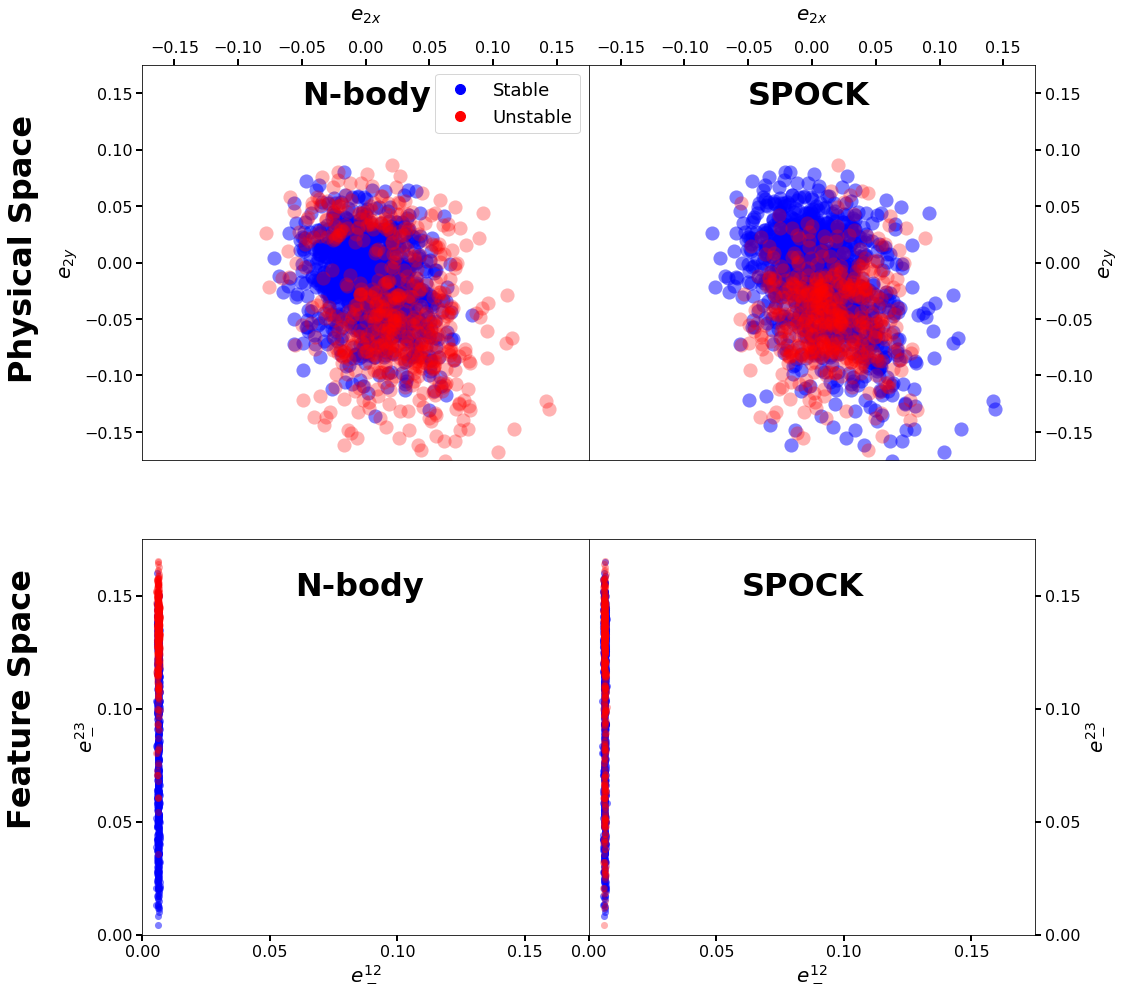

In [24]:
from matplotlib.lines import Line2D

fig, axarr = plt.subplots(nrows=2, ncols=2, figsize=[16, 16])
plt.subplots_adjust(wspace=0)

for ax in axarr.flatten():
    ax.set_rasterization_zorder(1)

s=200
axarr[0,0].scatter(df["k"][stablemask], df["h"][stablemask], c='b', s=s, lw=0, label='Stable', alpha=0.5, zorder=0)
axarr[0,0].scatter(df["k"][unstablemask], df["h"][unstablemask], c='r', s=s, lw=0, label='Unstable', alpha=0.3, zorder=0)
axarr[0,1].scatter(df["k"][pstablemask], df["h"][pstablemask], c='b', s=s, lw=0, label='Stable', alpha=0.5, zorder=0)
axarr[0,1].scatter(df["k"][punstablemask], df["h"][punstablemask], c='r', s=s, lw=0, label='Unstable', alpha=0.3, zorder=0)
axarr[0,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[0,0].text(-0.05, 0.14, 'N-body', weight='bold', size=32)
axarr[0,1].text(-0.05, 0.14, 'SPOCK', weight='bold', size=32)
axarr[0,0].text(-0.28, -0.1, 'Physical Space', weight='bold', size=32, rotation=90)

lim = 0.175
axarr[0,0].set_xlim([-lim, lim])
axarr[0,0].set_ylim([-lim, lim])
axarr[0,1].set_xlim([-lim, lim])
axarr[0,1].set_ylim([-lim, lim])

legend_elements = [Line2D([0], [0], marker='o', lw=0, c='b', markerfacecolor='b', label='Stable', markersize=10),
                   Line2D([0], [0], marker='o', lw=0, c='r', markerfacecolor='r', label='Unstable', markersize=10)]
axarr[0,0].legend(handles=legend_elements, loc='upper right', fontsize=18)

axarr[0,1].yaxis.tick_right()
axarr[0,0].xaxis.tick_top()
axarr[0,1].xaxis.tick_top()


axarr[0,0].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,0].set_ylabel(r'$e_{2y}$')
axarr[0,1].set_xlabel(r'$e_{2x}$', labelpad=20)
axarr[0,1].set_ylabel(r'$e_{2y}$')
axarr[0,1].yaxis.set_label_position("right")
axarr[0,0].xaxis.set_label_position("top")
axarr[0,1].xaxis.set_label_position("top")

s=50
axarr[1,0].scatter(df["Z12"][stablemask], df["Z23"][stablemask], c='b', s=s, lw=0, label='Stable', alpha=0.5, zorder=0)
axarr[1,0].scatter(df["Z12"][unstablemask], df["Z23"][unstablemask], c='r', s=s, lw=0, label='Unstable', alpha=0.3, zorder=0)
axarr[1,1].scatter(df["Z12"][pstablemask], df["Z23"][pstablemask], c='b', s=s, lw=0, label='Stable', alpha=0.5, zorder=0)
axarr[1,1].scatter(df["Z12"][punstablemask], df["Z23"][punstablemask], c='r', s=s, lw=0, label='Unstable', alpha=0.3, zorder=0)
axarr[1,1].tick_params(axis='y', which='both', left='off', right='off')
axarr[1,0].text(0.06, 0.15, 'N-body', weight='bold', size=32)
axarr[1,1].text(0.06, 0.15, 'SPOCK', weight='bold', size=32)
axarr[1,0].text(-0.053, 0.05, 'Feature Space', weight='bold', size=32, rotation=90)

axarr[1,0].set_xlim([0, lim])
axarr[1,0].set_ylim([0, lim])
axarr[1,1].set_xlim([0, lim])
axarr[1,1].set_ylim([0, lim])
axarr[1,0].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,0].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_xticks([0, 0.05, 0.1, 0.15])
axarr[1,1].set_yticks([0, 0.05, 0.1, 0.15])
axarr[1,1].yaxis.tick_right()
axarr[1,1].yaxis.set_label_position("right")

axarr[1,0].set_xlabel(r'$e_-^{12}$')
axarr[1,0].set_ylabel(r'$e_-^{23}$')
axarr[1,1].set_xlabel(r'$e_-^{12}$')
axarr[1,1].set_ylabel(r'$e_-^{23}$')

fig.savefig('KOI1576.pdf', bbox_inches='tight')

In [28]:
from xgboost.sklearn import XGBClassifier

tdata = pd.read_csv('../training_data/TTVsystems/KOI-1576/featuresNorbits10000.0Nout80trio/trainingdata.csv', index_col=0)

threshold = 0.967
model = XGBClassifier()
model.load_model('../spock/models/megno.json')
        
proba = model.predict_proba(pd.DataFrame(tdata['MEGNO'], columns=['MEGNO']))[:,1]
unstablemask = df['Stable'] == False
punstablemask = proba < threshold

FPR = 1-(punstablemask & unstablemask).sum()/unstablemask.sum()

print("FPR = {0:.3f}".format(FPR))  

FPR = 0.572
